# Data Setup

In [1]:
import pandas as pd
import numpy as np
import patsy
import matplotlib.pyplot as plt
%matplotlib inline

pd.core.common.is_list_like = pd.api.types.is_list_like
from pandas_datareader import data
from math import sqrt
import quandl
quandl.ApiConfig.api_key = "Xe_Akn13ZTp5zvsxoJs7"

In [2]:
# grab all NYSE stock tickers
stocks = pd.read_csv('./data/NYSE.txt',delimiter="\t")
stocks_list = []

# append to empty list
for symbol in stocks['Symbol']:
    stocks_list.append(symbol)

In [3]:
len(stocks_list)

3159

In [4]:
# get fortune 500 tickers
f500 = pd.read_csv('https://raw.githubusercontent.com/datasets/s-and-p-500-companies/master/data/constituents.csv')
tickers = f500.Symbol.tolist()

In [5]:
df = quandl.get("WIKI/" + 'AAPL', start_date="2014-01-01")

In [6]:
df.tail()

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2018-03-21,175.04,175.09,171.26,171.270,35247358.0,0.0,1.0,175.04,175.09,171.26,171.270,35247358.0
2018-03-22,170.00,172.68,168.60,168.845,41051076.0,0.0,1.0,170.00,172.68,168.60,168.845,41051076.0
2018-03-23,168.39,169.92,164.94,164.940,40248954.0,0.0,1.0,168.39,169.92,164.94,164.940,40248954.0
2018-03-26,168.07,173.10,166.44,172.770,36272617.0,0.0,1.0,168.07,173.10,166.44,172.770,36272617.0
2018-03-27,173.68,175.15,166.92,168.340,38962839.0,0.0,1.0,173.68,175.15,166.92,168.340,38962839.0


In [7]:
len(df)

1064

In [8]:
df['Split Ratio'].value_counts()

1.0    1063
7.0       1
Name: Split Ratio, dtype: int64

In [9]:
df[df['Split Ratio'] == 7.0]

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2014-06-09,92.7,93.88,91.75,93.7,75414997.0,0.0,7.0,87.252203,88.362857,86.358033,88.193435,75414997.0


In [10]:
aapl_split = quandl.get("WIKI/" + 'AAPL', start_date="2014-06-10")
aapl_split.tail()

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2018-03-21,175.04,175.09,171.26,171.270,35247358.0,0.0,1.0,175.04,175.09,171.26,171.270,35247358.0
2018-03-22,170.00,172.68,168.60,168.845,41051076.0,0.0,1.0,170.00,172.68,168.60,168.845,41051076.0
2018-03-23,168.39,169.92,164.94,164.940,40248954.0,0.0,1.0,168.39,169.92,164.94,164.940,40248954.0
2018-03-26,168.07,173.10,166.44,172.770,36272617.0,0.0,1.0,168.07,173.10,166.44,172.770,36272617.0
2018-03-27,173.68,175.15,166.92,168.340,38962839.0,0.0,1.0,173.68,175.15,166.92,168.340,38962839.0


In [11]:
# calculate MACD (a key trading metric)
aapl_split['MACD'] = (aapl_split.Close.ewm(span=12).mean() - aapl_split.Close.ewm(span=26).mean())

In [12]:
len(aapl_split)

955

In [13]:
# Google Trends
aapl_trends = pd.read_csv('data/AAPL_google_trends.csv', header=1)
aapl_trends.tail()

,Week,Apple: (Worldwide)
194,2018-03-04,30
195,2018-03-11,30
196,2018-03-18,29
197,2018-03-25,33
198,2018-04-01,30


In [14]:
# resample stock data to weekly
aapl_split_week = aapl_split.resample('W', convention='end').last()

aapl_split_week.tail()

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume,MACD
Date,,,,,,,,,,,,,
2018-03-04,172.80,176.30,172.45,176.21,38453950.0,0.0,1.0,172.80,176.30,172.45,176.21,38453950.0,2.177756
2018-03-11,177.96,180.00,177.39,179.98,31385134.0,0.0,1.0,177.96,180.00,177.39,179.98,31385134.0,2.394969
2018-03-18,178.65,179.12,177.62,178.02,36836456.0,0.0,1.0,178.65,179.12,177.62,178.02,36836456.0,2.392106
2018-03-25,168.39,169.92,164.94,164.94,40248954.0,0.0,1.0,168.39,169.92,164.94,164.94,40248954.0,-0.368963
2018-04-01,173.68,175.15,166.92,168.34,38962839.0,0.0,1.0,173.68,175.15,166.92,168.34,38962839.0,-0.764542


In [15]:
# join google trends and remove adjusted and other columns
asw = aapl_split_week.join(aapl_trends.set_index('Week'))
asw.drop(columns = ['Ex-Dividend',
       'Split Ratio', 'Adj. Open', 'Adj. High', 'Adj. Low', 'Adj. Close',
       'Adj. Volume'], inplace=True)

In [16]:
# rename
asw = asw.rename(columns = {'Apple: (Worldwide)':'google_trends'})

## Statistics

In [17]:
# run ADF to determine unit root
import statsmodels.tsa.stattools as ts
cadf = ts.adfuller(aapl_split.Close)

print('Augmented Dickey Fuller:')
print('Test Statistic =',cadf[0])
print('p-value =',cadf[1])
print('Critical Values =',cadf[4])

Augmented Dickey Fuller:
Test Statistic = -0.7311949821756538
p-value = 0.8385030452760827
Critical Values = {'1%': -3.43722314744835, '5%': -2.8645743628401763, '10%': -2.5683856650361054}


In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

MSFT = quandl.get("WIKI/" + 'MSFT', start_date="2014-06-10")
INTC = quandl.get("WIKI/" + 'INTC', start_date="2014-06-10")
TIF = quandl.get("WIKI/" + 'TIF', start_date="2014-06-10")

In [19]:
len(INTC)

955

In [20]:
len(MSFT)

956

/Users/jb/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


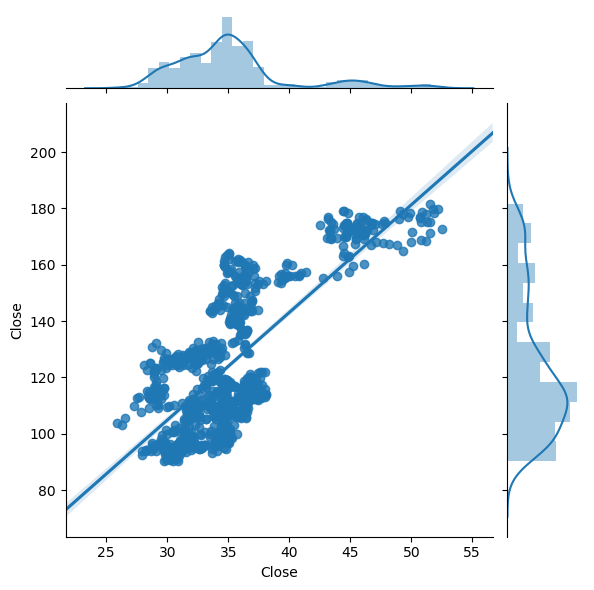

In [21]:
sns.jointplot(INTC.Close, aapl_split.Close, kind="reg");

In [22]:
# this is concurrent
np.corrcoef(INTC.Close, aapl_split.Close)

array([[1.        , 0.74339986],
       [0.74339986, 1.        ]])

In [23]:
# seven day lead
np.corrcoef(INTC.Close[:-7], aapl_split.Close[7:])

array([[1.        , 0.73320604],
       [0.73320604, 1.        ]])

In [24]:
# trend and price corr
np.corrcoef(aapl_trends['Apple: (Worldwide)'], aapl_split_week.Close)

array([[1.        , 0.04539983],
       [0.04539983, 1.        ]])

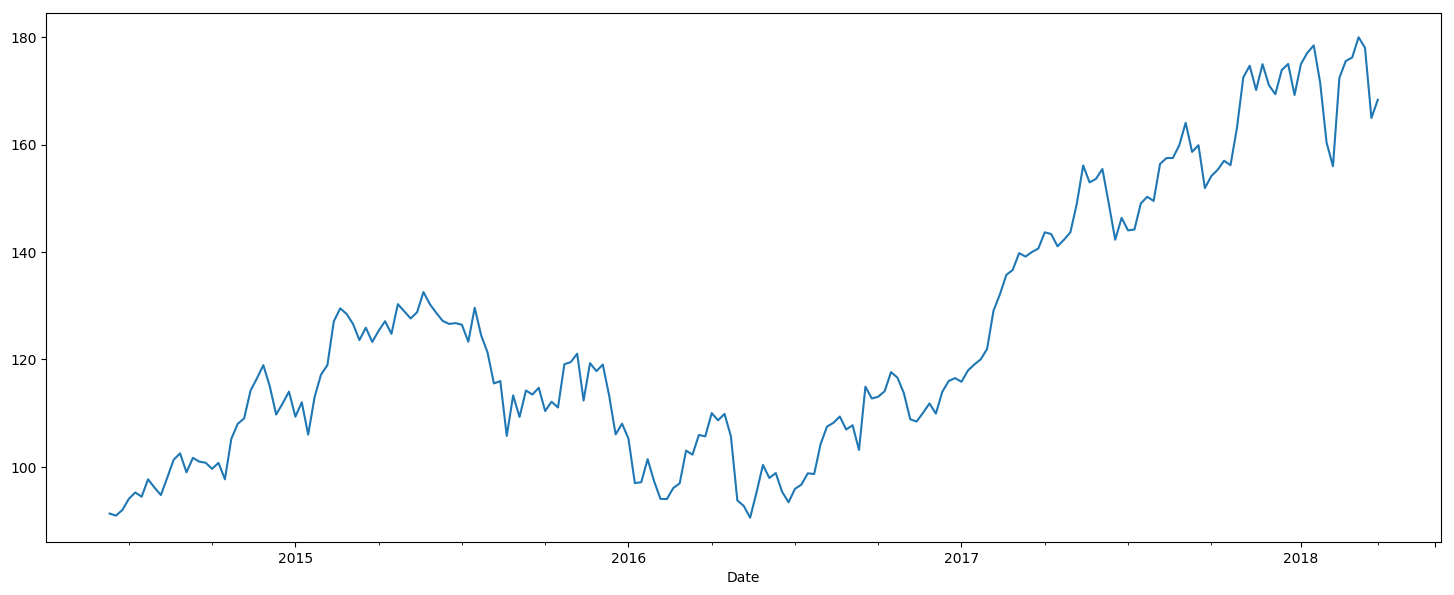

In [25]:
aapl_split_week.Close.plot();

In [26]:
aapl_split_week.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Ex-Dividend', 'Split Ratio',
       'Adj. Open', 'Adj. High', 'Adj. Low', 'Adj. Close', 'Adj. Volume',
       'MACD'],
      dtype='object')

# ARIMA

In [27]:
# check for minimum variance
print(aapl_split_week.Close.std())
print(aapl_split_week.Close.diff().std())
print(aapl_split_week.Close.diff().diff().std())
print(aapl_split_week.Close.diff().diff().diff().std())

24.67813156581174
4.136784064890053
6.000855950552649
10.430941061905392


In [28]:
import statsmodels.tsa.api as smt

def plots(data, lags=None):
    layout = (1, 3)
    raw  = plt.subplot2grid(layout, (0, 0))
    acf  = plt.subplot2grid(layout, (0, 1))
    pacf = plt.subplot2grid(layout, (0, 2))
    
    data.plot(ax=raw)
    smt.graphics.plot_acf(data, lags=lags, ax=acf)
    smt.graphics.plot_pacf(data, lags=lags, ax=pacf)
    sns.despine()
    plt.tight_layout()

In [29]:
# we might need to install dev version for statespace functionality
#!pip install git+https://github.com/statsmodels/statsmodels.git
import statsmodels.api as sm

# fit SARIMAX on weekly data
sar = sm.tsa.statespace.SARIMAX(aapl_split_week.Close, order=(1,0,0), seasonal_order=(1,1,0,52), trend='c').fit(transparams=False)
sar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              Close   No. Observations:                  199
Model:             SARIMAX(1, 0, 0)x(1, 1, 0, 52)   Log Likelihood                -456.156
Date:                            Thu, 18 Apr 2019   AIC                            920.312
Time:                                    10:40:20   BIC                            932.274
Sample:                                06-15-2014   HQIC                           925.173
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.6036      0.558      1.081      0.280      -0.491       1.698
ar.L1          0.9744      0.018     53.502      0.000       0.939       1.010
ar.S.L52      -0.5043      0.081     -6.250      0.000      -0.663      -0.346
sigma2        25.6990      3.196      8.040      0.000      19.434      31.964
===================================================================================
Ljung-Box (Q):                       39.42   Jarque-Bera (JB):                 0.07
Prob(Q):                              0.50   Prob(JB):                         0.97
Heteroskedasticity (H):               1.62   Skew:                            -0.05
Prob(H) (two-sided):                  0.09   Kurtosis:                         3.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

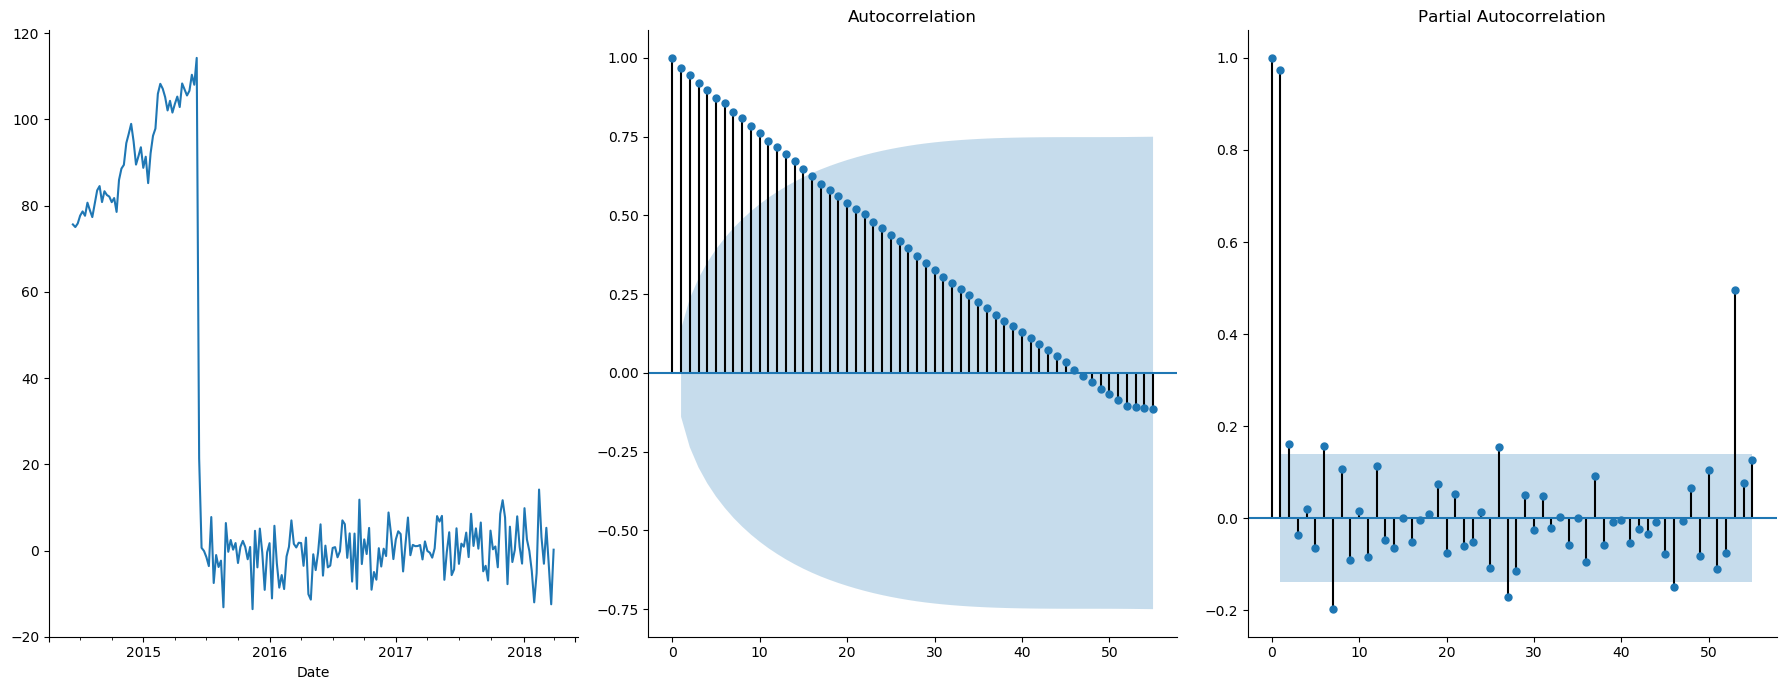

In [30]:
# plot resids
plots(sar.resid, lags=55);

# Thought process:
# 010010 is overdiff by AIC and negative ACR, but 000010 is a big underdiff with better AIC
# we pick 000010,12 and Trend='c' per rule4/5

# now look at seasonal, notice negative ACR spike at 12: per rule 13, we add a SMA term
# big drop to 4284 AIC
# looks like ACR looks good at seasonal lags, so we move back to ARIMA portion

# rule6 says we're a bit underdiff, so we add AR=3 based on PACF: 4261 AIC

# FB Prophet

In [31]:
from fbprophet import Prophet

# pull only close price and set up dataframe for prophet
aapl_fb = asw.loc[:, ['Close']]
aapl_fb['ds'] = asw.index
aapl_fb = aapl_fb.rename(columns={'Close': 'y'})

In [32]:
# fit model without final thirty periods
m = Prophet(weekly_seasonality=True, daily_seasonality=False)
m.fit(aapl_fb.iloc[:-30,:]);

# create future dataset
future = m.make_future_dataframe(periods=43, freq='W')
future.tail()

/Users/jb/anaconda3/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


,ds
207,2018-06-03
208,2018-06-10
209,2018-06-17
210,2018-06-24
211,2018-07-01


In [33]:
# check endpoint for train
aapl_fb.iloc[-30,:]

y                  158.63
ds    2017-09-10 00:00:00
Name: 2017-09-10 00:00:00, dtype: object

In [34]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
207,2018-06-03,208.285442,196.163453,222.177640
208,2018-06-10,206.477269,193.842955,219.896954
209,2018-06-17,204.303946,190.734072,218.514909
210,2018-06-24,203.639751,190.108344,218.146068
211,2018-07-01,204.845703,191.059623,219.737995


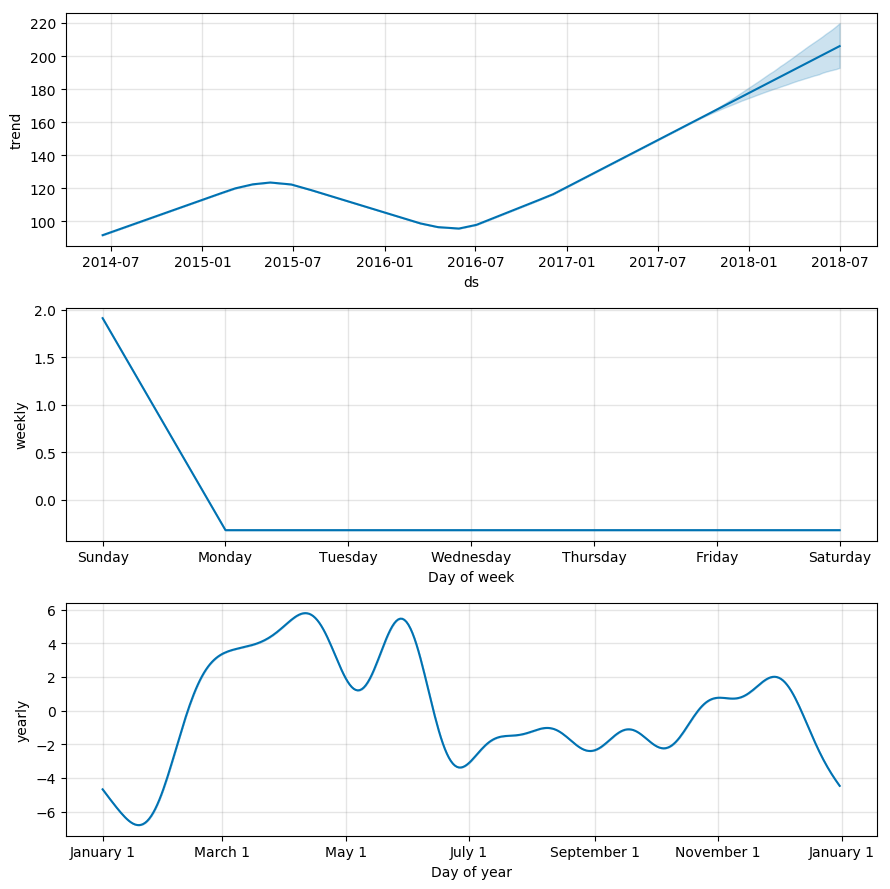

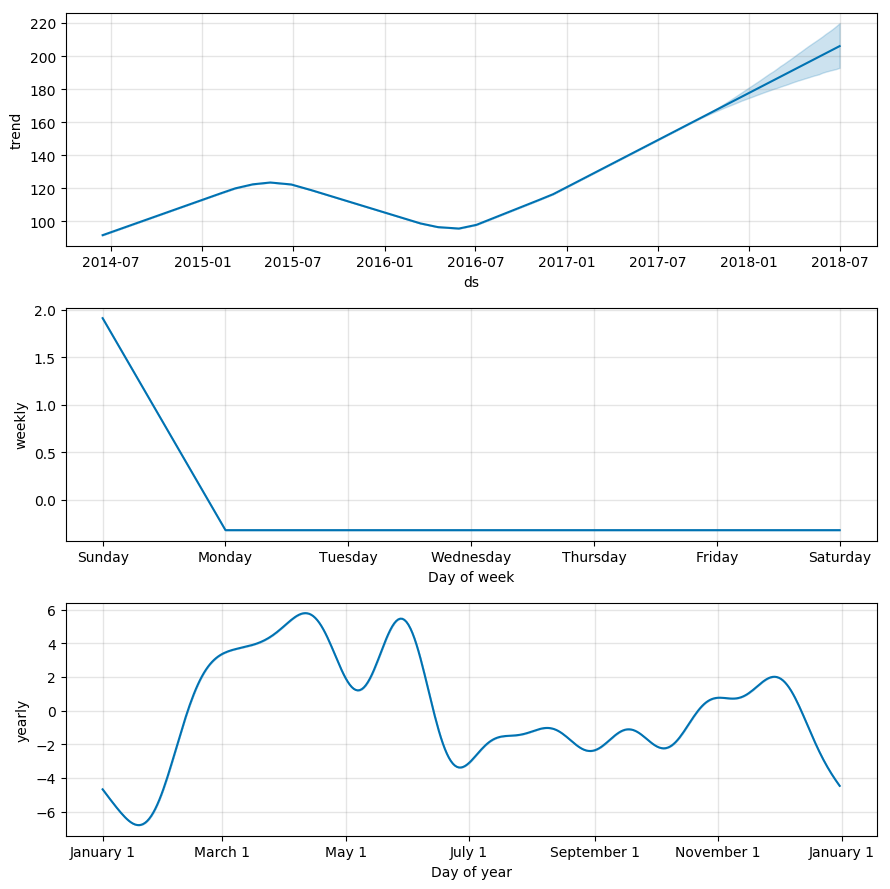

In [35]:
m.plot_components(forecast)

In [36]:
# Create mask that asks if the differential on the trend is upwards
mask = forecast['trend'].diff().iloc[-10:] > 0

# If they're all true 
if mask.all() == True:
    # Prophet thinks we're on the way down
    prophet_signal = 1
else:
    # Prophet thinks we're on the way up
    prophet_signal = 0

In [37]:
mask

202    True
203    True
204    True
205    True
206    True
207    True
208    True
209    True
210    True
211    True
Name: trend, dtype: bool

## XGBoost

In [38]:
X_train = X.iloc[:700,:]
X_test = X.iloc[700:-1,:]

y_train = df.Close.iloc[1:701]
y_test = df.Close.iloc[701:]

NameError: name 'X' is not defined

## SKLearn

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression

#X, y = make_regression(n_features=4, n_informative=2, random_state=0, shuffle=False)

regr = RandomForestRegressor(max_depth=5, random_state=0)
regr.fit(X_train, y_train)

print(regr.feature_importances_)

In [ ]:
regr.score(X_test, y_test)

In [ ]:
regr.predict(df.iloc[800:,:])

# Turi
`source activate venv`

In [ ]:
import turicreate as tc

## Text Classification

In [ ]:

import twitter
import tweepy
from requests_oauthlib import OAuth1

import cnfg
config = cnfg.load(".twitter_config")

oauth = OAuth1(config["consumer_key"],
               config["consumer_secret"],
               config["access_token"],
               config["access_token_secret"])

In [ ]:
auth = tweepy.OAuthHandler(config["consumer_key"],
                           config["consumer_secret"])
auth.set_access_token(config["access_token"],
                      config["access_token_secret"])

api=tweepy.API(auth)

In [ ]:
results=[]

for tweet in tweepy.Cursor(api.search,q="AAPL").items(10):
    results.append(tweet)

In [ ]:
results

## Textblob


In [ ]:
from textblob import TextBlob
import re

def clean_tweet(tweet):
    '''
    Utility function to clean the text in a tweet by removing 
    links and special characters using regex.
    '''
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())

def analize_sentiment(tweet):
    '''
    Utility function to classify the polarity of a tweet
    using textblob.
    '''
    analysis = TextBlob(clean_tweet(tweet))
    if analysis.sentiment.polarity > 0:
        return 1
    elif analysis.sentiment.polarity == 0:
        return 0
    else:
        return -1

In [ ]:
# Create a model
model = tc.text_classifier.create(data, 'rating', features=['text'])

# Make predictions & evaluation the model
predictions = model.predict(data)
results = model.evaluate(data)

# Save the model for later use in Turi Create
model.save('MyTextClassifier.model')

# Export for use in Core ML
model.export_coreml('MySentenceClassifier.mlmodel')

## Turi Models

![](./assets/turi/turi.jpg)

In [ ]:
# prep data by shifting one week and two weeks ahead

asw['final_close1'] = asw.Close.shift(-1)
asw['final_close2'] = asw.Close.shift(-2)


# chop the nulls off the tail
asw = asw.iloc[:-2,:]
asw.tail()

![](./assets/turi/Sframe.jpg)

In [ ]:
# Load the data
data =  tc.SFrame(data=asw)

In [ ]:
# explore tabular
data.explore()

In [ ]:
# explore with plots
data.show()

In [ ]:
# train-test split
train_data, test_data = data.random_split(.8)


![](./assets/turi/models.jpg)

In [ ]:
# Automatically pick the right model based on data
model1 = tc.regression.create(train_data, target='final_close1',
                                    features = ['Open',
                                                'High',
                                                'Low',
                                                'Close',
                                                'google_trends'])

In [ ]:
# Save predictions to an SArray
predictions = model1.predict(test_data)

# Evaluate the model and save the results into a dictionary
results1 = model1.evaluate(test_data)

In [ ]:
results1

In [ ]:
# build model for two week lag
model2 = tc.regression.create(train_data, target='final_close2',
                                    features = ['Open',
                                                'High',
                                                'Low',
                                                'Close',
                                                'google_trends'])

In [ ]:
predictions = model2.predict(test_data)

results2 = model2.evaluate(test_data)

In [ ]:
results2

In [ ]:
# plot week lag prediction vs actual
plt.plot(model2.predict(data), 'r')
plt.plot(data['final_close1'], 'g')
plt.title('AAPL Predicted vs. Actual for Two-Week Lead')
plt.legend(('Predicted', 'Actual'));

>How would we do if we dropped google trends data?

In [ ]:
model_no_trends = tc.regression.create(train_data, target='final_close1',
                                        features = ['Open',
                                                    'High',
                                                    'Low',
                                                    'Close'], verbose=False)

In [ ]:
predictions = model_no_trends.predict(test_data)
model_no_trends.evaluate(test_data)

#small bump in max error and rmse across many runs

### Compare to `sklearn` RandomForestRegressor

In [ ]:
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestRegressor
import patsy

y, X = patsy.dmatrices('final_close1 ~ Open + High + Low + Close + google_trends', data=asw)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

In [ ]:
rfr = RandomForestRegressor()
rfr.fit(X_train, y_train.ravel())

In [ ]:
print(rfr.feature_importances_)

# note patsy created an intercept

In [ ]:
pred = rfr.predict(X_test)

In [ ]:
rfr.score(X_test, y_test)

### Build and Validate a Trading Algorithm

We can take a number of approaches, but the simplest is to buy if next week's prediction is higher and sell if it's lower.

Assumptions:
 - we start enough funds for one stock
 - no put options
 - fixed transaction cost regardless of volume bought or sold
 - only make money buying low and selling high
 - opportunity cost in the bull market is buying and sitting till end of timeframe

In [ ]:
# predict across span of time
pred = model1.predict(data)
pred[:5]

In [ ]:
data

In [ ]:
# pull true values
true = data['final_close1']
true[:5]

In [ ]:
# if predicted is higher than current close, buy
#def profits(data, pred, true):
tally = []
transactions = 0
invested = False
cash = 0

for i in range(len(true)):
    if pred[i] > data['Close'][i] and invested == False: # buy and flag as invested
        invested = True
        transactions +=1
        buy_price = data['Close'][i]
        print('buy: $' + str(buy_price))
    elif pred[i] > data['Close'][i] and invested == True:
        continue
    elif pred[i] < data['Close'][i] and invested == True:
        tally.append(true[i] - buy_price)
        invested = False
        transactions +=1
        print(true[i] - buy_price)
    else:
        print('wait')

In [ ]:
len(tally)

In [ ]:
len(true)

In [ ]:
transactions

In [ ]:
sum(tally)

# we made close to $100

In [ ]:
plt.hist(tally);

In [ ]:
# compare to buy and hold
data['Close'][-1] - data['Close'][0]

Our trading strategy nets us **$99$ - $86$ =**

**$13 /stock**

We haven't taken the 62 transactions into account, but at a fixed price, the variable profit should compensate. In a bull market, like AAPL and other stocks experienced during 2014-2018, it's easy to make money using most any strategy. The real test is during periods of variability or correction. We can pull relevant time periods, but should ALWAYS remember to retrain our model when market conditions experience fundamental shifts. 